## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time

from IPython.display import clear_output

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [18]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [19]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [20]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [21]:
len(fmnist_dataset_test)

10000

In [22]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [28]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Dropout(p = 0.3),
            nn.Linear(200, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [29]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
       BatchNorm1d-4                  [-1, 500]           1,000
            Linear-5                  [-1, 200]         100,200
              ReLU-6                  [-1, 200]               0
           Dropout-7                  [-1, 200]               0
            Linear-8                   [-1, 10]           2,010
Total params: 495,710
Trainable params: 495,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.89
Estimated Total Size (MB): 1.92
----------------------------------------------------------------


In [30]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) 
            # move data to target device
            ### YOUR CODE HERE
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            loss.backward()
            opt.step()
            opt.zero_grad()
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device) 
                # move data to target device
                ### YOUR CODE HERE

                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                # compute predictions
                ### YOUR CODE HERE
                ep_val_loss.append(loss.item())
                y_gt = y_batch.cpu().numpy().ravel()
                preds = np.argmax(y_pred.detach().cpu().numpy(), axis=1).ravel()
                ep_val_accuracy.append(np.mean((y_gt == preds).astype(float)))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

Your experiments come here:

In [31]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
opt.zero_grad()
# Your experiments, training and validation loops here

In [32]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 9.623s
	  training loss: 0.456114
	validation loss: 0.398191
	validation accuracy: 0.856
Epoch 2 of 30 took 9.276s
	  training loss: 0.364702
	validation loss: 0.384143
	validation accuracy: 0.861
Epoch 3 of 30 took 9.555s
	  training loss: 0.341798
	validation loss: 0.400237
	validation accuracy: 0.852
Epoch 4 of 30 took 9.349s
	  training loss: 0.324070
	validation loss: 0.379519
	validation accuracy: 0.869
Epoch 5 of 30 took 9.402s
	  training loss: 0.301660
	validation loss: 0.372663
	validation accuracy: 0.865
Epoch 6 of 30 took 9.300s
	  training loss: 0.288708
	validation loss: 0.345870
	validation accuracy: 0.878
Epoch 7 of 30 took 9.344s
	  training loss: 0.276944
	validation loss: 0.349619
	validation accuracy: 0.876
Epoch 8 of 30 took 9.405s
	  training loss: 0.269153
	validation loss: 0.343594
	validation accuracy: 0.880
Epoch 9 of 30 took 9.249s
	  training loss: 0.260400
	validation loss: 0.350427
	validation accuracy: 0.875
Epoch 10 of 30 took 9.282s
	

In [33]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].set_xlabel('epochs')
    axes[0].set_ylabel('loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()


    axes[1].axhline(0.885, color='r', label=f'desired accuracy')
    axes[1].set_title('Validation accuracy')
    axes[1].set_xlabel('epochs')
    axes[1].set_ylabel('accuracy')
    axes[1].plot(val_accuracy)

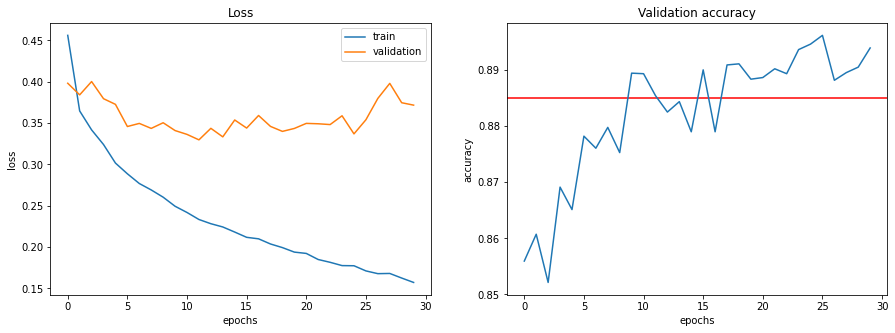

In [34]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [39]:
train_loader_1 = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)
test_loader_1 = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=128,
                                          shuffle=False,
                                          num_workers=2)

In [52]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 10),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [53]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
       BatchNorm1d-4                  [-1, 200]             400
            Linear-5                   [-1, 10]           2,010
Total params: 159,410
Trainable params: 159,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.61
Estimated Total Size (MB): 0.62
----------------------------------------------------------------


In [54]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
opt.zero_grad()
# Your experiments, come here

In [55]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader_1, test_loader_1, loss_func, opt, n_epochs)

Epoch 1 of 30 took 8.181s
	  training loss: 0.478508
	validation loss: 0.428973
	validation accuracy: 0.847
Epoch 2 of 30 took 8.153s
	  training loss: 0.359733
	validation loss: 0.407808
	validation accuracy: 0.847
Epoch 3 of 30 took 8.575s
	  training loss: 0.328134
	validation loss: 0.455594
	validation accuracy: 0.849
Epoch 4 of 30 took 8.053s
	  training loss: 0.309638
	validation loss: 0.381496
	validation accuracy: 0.864
Epoch 5 of 30 took 8.153s
	  training loss: 0.295620
	validation loss: 0.375106
	validation accuracy: 0.862
Epoch 6 of 30 took 8.136s
	  training loss: 0.283496
	validation loss: 0.349555
	validation accuracy: 0.876
Epoch 7 of 30 took 8.233s
	  training loss: 0.273150
	validation loss: 0.351825
	validation accuracy: 0.874
Epoch 8 of 30 took 8.100s
	  training loss: 0.265014
	validation loss: 0.362702
	validation accuracy: 0.871
Epoch 9 of 30 took 8.093s
	  training loss: 0.258173
	validation loss: 0.339979
	validation accuracy: 0.879
Epoch 10 of 30 took 8.078s
	

In [58]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation with normalixation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

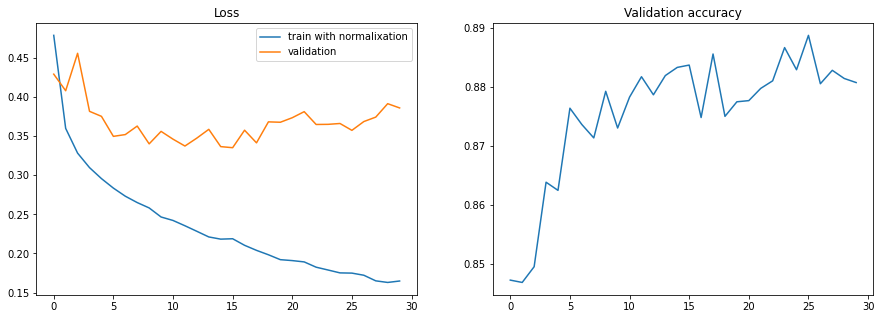

In [59]:
plot_train_process(train_loss, val_loss, val_accuracy)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                   [-1, 10]           2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.61
Estimated Total Size (MB): 0.62
----------------------------------------------------------------
Epoch 1 of 30 took 7.855s
	  training loss: 0.633242
	validation loss: 0.487937
	validation accuracy: 0.830
Epoch 2 of 30 took 7.900s
	  training loss: 0.433425
	validation loss: 0.444850
	validation accuracy: 0.843
Epoch 3 of 30 took 7.801s
	  training loss: 0.393457
	validation loss: 0.429154
	v

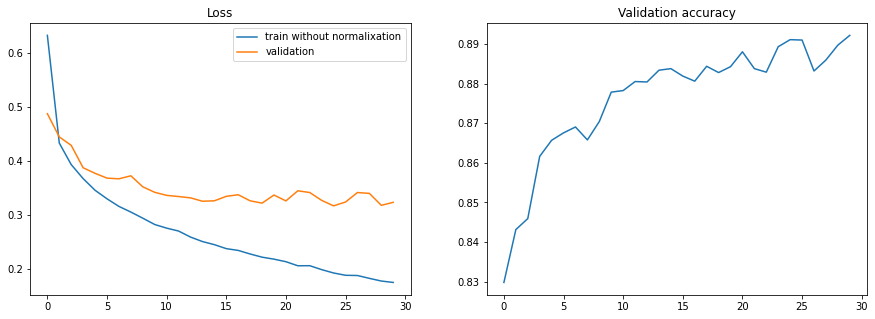

In [60]:
class OverfittingNeuralNetwork_1(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
torchsummary.summary(OverfittingNeuralNetwork_1().to(device), (28*28,))
model = OverfittingNeuralNetwork_1().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
opt.zero_grad()
n_epochs = 30
train_loss, val_loss, val_accuracy = train_model(model, train_loader_1, test_loader_1, loss_func, opt, n_epochs)
def plot_train_process_1(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation without normalixation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)
plot_train_process_1(train_loss, val_loss, val_accuracy)

Я поменял размеры тестовой и тренировочной выборки местами, и на первом графике видно, что при значительном падении loss на обучающей выборке, loss на тренировочной выборке почти не меняется.

Странно, что при добавлении Нормализации после модуля ReLU результаты хуже

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [68]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.ELU(),
            nn.BatchNorm1d(200),
            nn.Dropout(p = 0.3),
            nn.Softmax(dim=1),
            nn.BatchNorm1d(200),
            nn.Linear(200, 100),
            nn.Dropout(p = 0.5),
            nn.Softplus(),
            nn.Linear(100, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [69]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
       BatchNorm1d-4                  [-1, 500]           1,000
            Linear-5                  [-1, 200]         100,200
              ReLU-6                  [-1, 200]               0
               ELU-7                  [-1, 200]               0
       BatchNorm1d-8                  [-1, 200]             400
           Dropout-9                  [-1, 200]               0
          Softmax-10                  [-1, 200]               0
      BatchNorm1d-11                  [-1, 200]             400
           Linear-12                  [-1, 100]          20,100
          Dropout-13                  [-1, 100]               0
         Softplus-14                  [

Epoch 1 of 60 took 10.314s
	  training loss: 0.573796
	validation loss: 0.444958
	validation accuracy: 0.845
Epoch 2 of 60 took 10.315s
	  training loss: 0.413799
	validation loss: 0.431393
	validation accuracy: 0.845
Epoch 3 of 60 took 10.216s
	  training loss: 0.376094
	validation loss: 0.391070
	validation accuracy: 0.863
Epoch 4 of 60 took 10.165s
	  training loss: 0.362750
	validation loss: 0.393956
	validation accuracy: 0.861
Epoch 5 of 60 took 10.220s
	  training loss: 0.345985
	validation loss: 0.378561
	validation accuracy: 0.865
Epoch 6 of 60 took 10.714s
	  training loss: 0.331543
	validation loss: 0.356245
	validation accuracy: 0.869
Epoch 7 of 60 took 10.202s
	  training loss: 0.318181
	validation loss: 0.343568
	validation accuracy: 0.877
Epoch 8 of 60 took 10.159s
	  training loss: 0.301997
	validation loss: 0.345174
	validation accuracy: 0.877
Epoch 9 of 60 took 10.251s
	  training loss: 0.296292
	validation loss: 0.373489
	validation accuracy: 0.863
Epoch 10 of 60 took

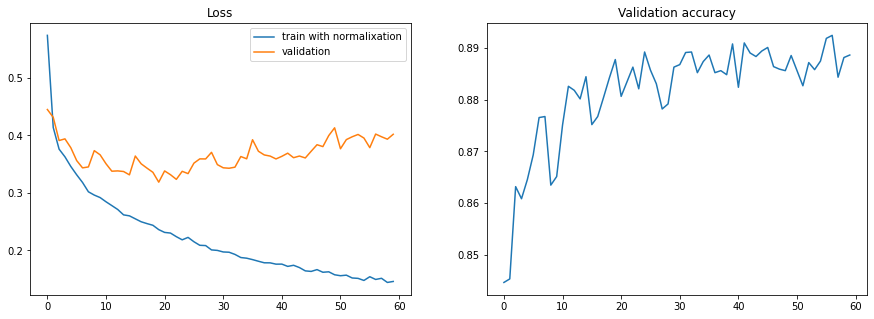

In [70]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
opt.zero_grad()
# Your experiments, come here
n_epochs = 60

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)
plot_train_process(train_loss, val_loss, val_accuracy)

### Conclusions:
_Write down small report with your conclusions and your ideas._
